<a href="https://colab.research.google.com/github/sk27110/MMK/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

#### Задача

Обучить любые две модели из списка, используя реальные данные, применить метод Монте-Карло для улучшения стабильности предсказаний и провести анализ качества результатов.

#### Список моделей

- Gradient Boosting
- XGBoost
- CatBoost
- Ridge Regression
- Lasso Regression
- ElasticNet

#### Инструкция

##### Подготовка данных

- Использовать данные из любой доступной базы (например, yfinance, datasets или аналоги).
- Обеспечить разделение данных на тренировочную и тестовую выборки.
- Нормализовать данные, если это необходимо для выбранных моделей.

##### Обучение моделей

- Обучить две модели из списка.
- Подобрать оптимальные параметры.

##### Применить методы Монте-Карло

- Провести симуляцию с методом Монте-Карло для обеих моделей:
    - Выполнить n симуляций (например, не меньше 30), обучая модель на случайных подвыборках тренировочных данных (bootstrap sampling).
    - Рассчитать среднее и стандартное отклонение предсказаний для тестовых данных.
- Построить доверительные интервалы для предсказаний.

##### Оценка моделей

- Вычислить метрики качества:
    - Среднеквадратическая ошибка (MSE).
    - Коэффициент детерминации (R²).
- Сравнить результаты метрик между моделями (без Монте-Карло и ним).

##### Визуализация результатов

- Построить график, показывающий:
    - Истинные значения.
    - Предсказанные значения для каждой модели.
- Добавить подписи, легенду и заголовок.

##### Вывод

Написать вывод о том, какая модель лучше справилась с задачей и почему (ориентироваться на метрики и визуализацию).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.impute import SimpleImputer

In [2]:
from datasets import load_dataset

ds = load_dataset("leostelon/california-housing")['train']
ds = ds.to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

housing.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20640 [00:00<?, ? examples/s]

In [3]:
ds.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
ds.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,object


In [5]:
X = ds.drop(columns=['median_house_value'])
y = ds['median_house_value']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
cat_col = ['ocean_proximity']
num_cols = X.columns.drop('ocean_proximity')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_col)
    ]
)

Подбираем гиперпараметры


In [8]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])


param_grid_ridge = {
    'model__alpha': np.logspace(-3, 3, 200).tolist()
}

ridge_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(st...
                                          0.0026430814869741054,
                                          0.002833096101839324,
                                          0.0030367711180354575,
                                          0.0032550885998350564,
                                          0.0034891012134067737,
                                          0.0037399373024787977,
                                          0.004008806328898464,
                                          0.00429700470432084,
                                          0.004605922041145103,
                                          0.004937047852839003,
                                          0.005291978735958442,
                                          0.005672426068491977,
                                          0.006080224261649421,
                                          0.00651733960488242,
                                          0.006985879746785249,
                                          0.007488103857590023, ...]},
             scoring='r2')

In [9]:
ridge_search.best_params_

{'model__alpha': 0.7316807143427192}

In [12]:
xgb_pipline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
    ])

xgb_param_grid = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__reg_alpha': uniform(0.001, 10),
    'model__reg_lambda': uniform(0.1, 10),
    'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipline,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=4,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True)

xgb_search.fit(X_train, y_train)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipel...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a15d85486b0>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a15d854bd10>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a15d8548530>},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=1)

In [13]:
xgb_search.best_params_

{'model__colsample_bytree': np.float64(0.8170784332632994),
 'model__gamma': 0,
 'model__learning_rate': np.float64(0.09888205171122472),
 'model__max_depth': 7,
 'model__min_child_weight': 1,
 'model__n_estimators': 444,
 'model__reg_alpha': np.float64(9.869869366005172),
 'model__reg_lambda': np.float64(7.822447692966573),
 'model__subsample': np.float64(0.679486272613669)}

Проводим 50 симуляций для каждой модели

In [36]:
n_simulations = 50
ridge_mse_scores = []
ridge_r_scores = []
predictions_ridge = []

for i in tqdm(range(n_simulations)):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    pipeline = clone(ridge_search.best_estimator_)
    pipeline.fit(X_boot, y_boot)
    pred = pipeline.predict(X_test)
    predictions_ridge.append(pred)
    mse_score = mean_squared_error(pred, y_test)
    r_score = r2_score(y_test, pred)
    ridge_mse_scores.append(mse_score)
    ridge_r_scores.append(r_score)

100%|██████████| 50/50 [00:01<00:00, 25.77it/s]


In [37]:
n_simulations = 50
xgb_mse_scores = []
xgb_r_scores = []
predictions_xgb = []

for i in tqdm(range(n_simulations)):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    pipeline = clone(xgb_search.best_estimator_)
    pipeline.fit(X_boot, y_boot)
    pred = pipeline.predict(X_test)
    predictions_xgb.append(pred)
    mse_score = mean_squared_error(pred, y_test)
    r_score = r2_score(y_test, pred)
    xgb_mse_scores.append(mse_score)
    xgb_r_scores.append(r_score)

100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


Теперь просто обучим модельки на трейне

In [39]:
ridge_pipeline = clone(ridge_search.best_estimator_)
ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

xgb_pipeline = clone(xgb_search.best_estimator_)
xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

In [48]:
predictions_ridge = np.array(predictions_ridge)
predictions_xgb = np.array(predictions_xgb)

Считаем среднее

In [49]:
mean_ridge = predictions_ridge.mean(axis=0)
std_ridge = predictions_ridge.std(axis=0)
lower_ridge = np.percentile(predictions_ridge, 2.5, axis=0)
upper_ridge = np.percentile(predictions_ridge, 97.5, axis=0)

mean_xgb = predictions_xgb.mean(axis=0)
std_xgb = predictions_xgb.std(axis=0)
lower_xgb = np.percentile(predictions_xgb, 2.5, axis=0)
upper_xgb = np.percentile(predictions_xgb, 97.5, axis=0)

Метрики


In [53]:
print("Ridge mean MSE:", np.mean(ridge_mse_scores))
print("Ridge std MSE:", np.std(ridge_mse_scores))
print("Ridge mean r^2:", np.mean(ridge_r_scores))
print("Ridge std r^2:", np.std(ridge_r_scores))


print("XGB mean MSE:", np.mean(xgb_mse_scores))
print("XGB std MSE:", np.std(xgb_mse_scores))
print("XGB mean r^2:", np.mean(xgb_r_scores))
print("XGB std r^2:", np.std(xgb_r_scores))

Ridge mean MSE: 4811272989.129507
Ridge std MSE: 27939089.9542325
Ridge mean r^2: 0.6363960732350002
Ridge std r^2: 0.0021114500965860867
XGB mean MSE: 2219762799.212188
XGB std MSE: 36561739.1543362
XGB mean r^2: 0.832245130944763
XGB std r^2: 0.002763092419804571


Строим графики

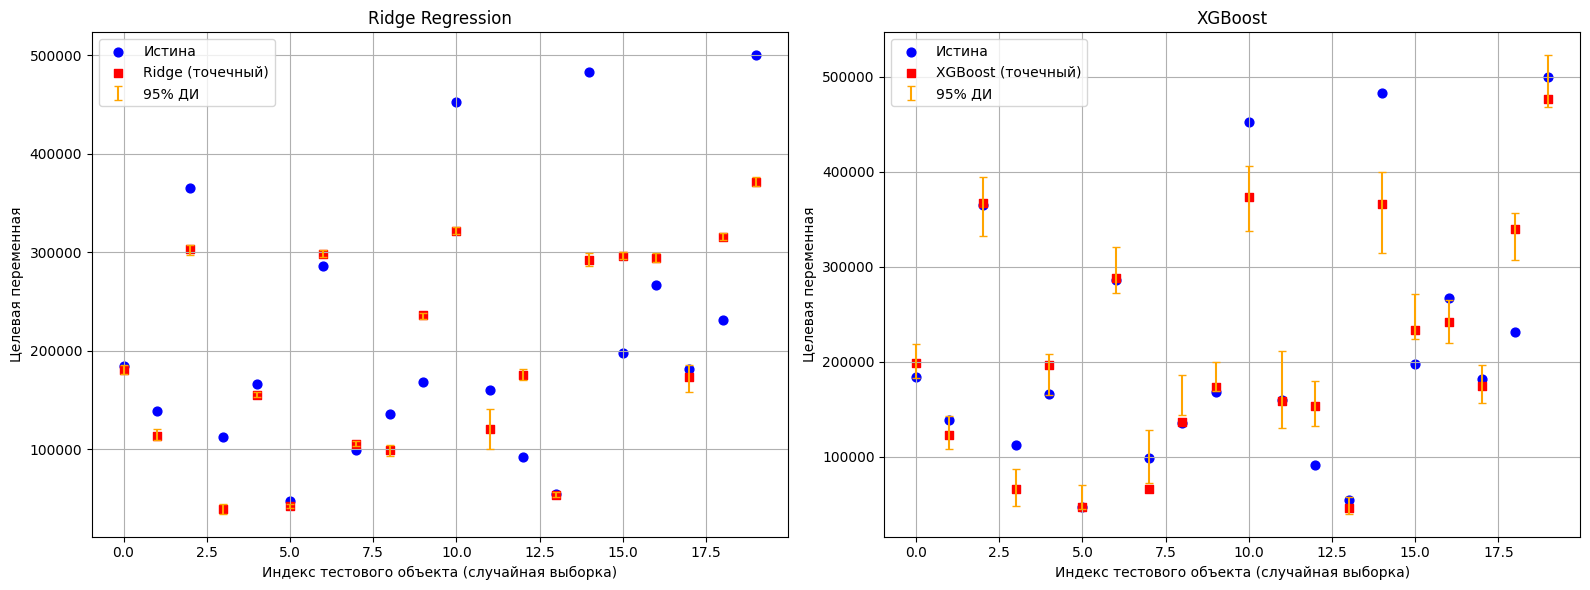

In [52]:
import matplotlib.pyplot as plt


n_plot = 20
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), size=n_plot, replace=False)
sample_indices.sort()


y_test_plot = y_test.iloc[sample_indices]



ridge_pred_plot = ridge_pred[sample_indices]
xgb_pred_plot = xgb_pred[sample_indices]

mean_ridge_plot = mean_ridge[sample_indices]
lower_ridge_plot = lower_ridge[sample_indices]
upper_ridge_plot = upper_ridge[sample_indices]

mean_xgb_plot = mean_xgb[sample_indices]
lower_xgb_plot = lower_xgb[sample_indices]
upper_xgb_plot = upper_xgb[sample_indices]

x_pos = np.arange(n_plot)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.scatter(x_pos, y_test_plot, label='Истина', marker='o', color='blue', s=40)
ax.scatter(x_pos, ridge_pred_plot, label='Ridge (точечный)', marker='s', color='red', s=40)
ax.errorbar(x_pos, mean_ridge_plot,
            yerr=[mean_ridge_plot - lower_ridge_plot, upper_ridge_plot - mean_ridge_plot],
            fmt='none', ecolor='orange', capsize=3, label='95% ДИ')
ax.set_title('Ridge Regression')
ax.set_xlabel('Индекс тестового объекта (случайная выборка)')
ax.set_ylabel('Целевая переменная')
ax.legend()
ax.grid(True)



ax = axes[1]
ax.scatter(x_pos, y_test_plot, label='Истина', marker='o', color='blue', s=40)
ax.scatter(x_pos, xgb_pred_plot, label='XGBoost (точечный)', marker='s', color='red', s=40)
ax.errorbar(x_pos, mean_xgb_plot,
            yerr=[mean_xgb_plot - lower_xgb_plot, upper_xgb_plot - mean_xgb_plot],
            fmt='none', ecolor='orange', capsize=3, label='95% ДИ')
ax.set_title('XGBoost')
ax.set_xlabel('Индекс тестового объекта (случайная выборка)')
ax.set_ylabel('Целевая переменная')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
XGB

В итоге XGBRegressor справился лучше модели Ridge. Метрики у XGB сильно лучше, чем у Ridge. Это можно объяснить тем, что XGB нелинейная модель. Так же у нее большая дисперсия (что можно видеть по большим доверительным интервалам), но маленький bias, у Ridge же все наоборот.